## Initial Setup

In [1]:
# Initial setup...
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import fitsio
from scipy import interpolate
import glob
import math
import os

import h5py
import bisect

import matplotlib.pyplot as plt

%matplotlib inline


## User input

In [2]:
# debug=True fits a single spectrum with a smaller set of models and over a smaller range of redshifts...
debug=False

# Directory name for the UCSC-processed spectra:
inputFile_obs_dirname = '/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_UCSC'

# Output directory...
output_dirname = '/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_analysis/FigOutput'


# AstroDash scripts directory...


if not debug:
    
    inputFile_obs_list = ['desgw-190814c.flm', 
                          'desgw-190814d.flm']

    cleanName_obs_dict = {'2019noq.flm':'AT2019noq', 
                          'AT2019npw-3.flm':'AT2019npw', 
                          'AT2019ntp.flm':'AT2019ntp', 
                          'AT2019num.flm':'AT2019num', 
                          'desgw-190814c.flm':'AT2019nqq', 
                          '2019ntn.flm':'AT2019ntn', 
                          'AT2019ntr.flm':'AT2019ntr', 
                          'desgw-190814d.flm':'AT2019nqr'}


    # Best-fit template from the synphot AGN directory...
    agn_dict = {'desgw-190814c.flm': 'seyfert2_template.fits', 
                'desgw-190814d.flm': 'seyfert2_template.fits'}

    # Best-fit AGN red...
    z_dict = {'desgw-190814c.flm': 0.071, 
              'desgw-190814d.flm': 0.083}


else:
    inputFile_obs_list = ['desgw-190814d.flm']
    cleanName_obs_dict = {'desgw-190814d.flm': 'AT2019nqr'}
    agn_dict           = {'desgw-190814d.flm': 'seyfert2_template.fits'}
    z_dict             = {'desgw-190814d.flm': 0.083}

    
# synphot parameters...
agn_dirname = '/usrdevel/dp0/dtucker/SynphotData/grp/hst/cdbs/grid/agn'


In [3]:
!ls /usrdevel/dp0/dtucker/SynphotData/grp/hst/cdbs/grid/agn

AA_README_AGN	     ngc1068_template.fits  seyfert1_template.fits
liner_template.fits  qso_template.fits	    seyfert2_template.fits


In [4]:
fname = '/usrdevel/dp0/dtucker/SynphotData/grp/hst/cdbs/grid/agn/seyfert2_template.fits'
from astropy.table import Table
t = Table.read(fname, hdu=1)
df = t.to_pandas()
df

,WAVELENGTH,FLUX
0,1235.0,1.644446e-14
1,1240.0,1.864344e-14
2,1245.0,1.823987e-14
3,1250.0,1.716666e-14
4,1255.0,1.180838e-14
5,1260.0,1.193796e-14
6,1265.0,1.457926e-14
7,1270.0,1.813268e-14
8,1275.0,1.757337e-14
9,1280.0,1.688907e-14


## Plot function

In [5]:
def plot_obs_and_bestfit_agn(obsname, obsname_clean, agn_dirname, agn_name, z, wavelength_array, df_obs_new, output_dirname):

    basename = agn_name
    name = agn_dirname+'/'+basename

    table_agn = Table.read(name, hdu=1)
    df_agn = table_agn.to_pandas()
    
    df_agn['WAVELENGTH'] = (1.+z)*df_agn['WAVELENGTH']
    
    spec_flux_agn = interpolate.interp1d(df_agn.WAVELENGTH, df_agn.FLUX,bounds_error=False, fill_value=0.,kind='linear')
    spec_flux_agn_array = spec_flux_agn(wavelength_array)

    df_agn_new = pd.DataFrame({'LAMBDA':wavelength_array, 'Flam':spec_flux_agn_array})

    norm = df_agn_new['Flam'].median()

    df_agn_new['normFlam'] = df_agn_new['Flam']/norm

    ax = df_agn_new.plot('LAMBDA','normFlam', c='#000000', label='AGN template', fontsize=18)
    df_obs_new.plot('LAMBDA', 'normFLUX', c='#56b4e9', alpha=0.8, label='Observed', fontsize=18, ax=ax)
    title = """%s""" % (obsname_clean)
    #title = """%s: ($z_b$=%.3f)""" % (/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_analysis/FigOutput, z)
    #title = """ $MSE$=%.2f, $z$=%.3f, $z_b$=%.3f""" % (sum2,z,z_best)
    plt.title(title, fontsize=35)
    ax.legend(loc='upper right', fontsize=14, framealpha=0.5)
    ax.set_xlabel('wavelength (observed frame) [$\\AA$]',fontsize=16)
    ax.set_ylabel('Relative $F_{\lambda}$',fontsize=16)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    textstr = """$z_{best}$=%.3f""" % (z)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    ax.grid(False)
    
    outputFile = """AGNfit.%s.png""" % (obsname_clean)
    outputFile = os.path.join(output_dirname, outputFile)
    
    plt.tight_layout()
    plt.savefig(outputFile)

    return 0


## Fit each input observed spectrum


/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_UCSC/desgw-190814c.flm
desgw-190814c.flm

/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_UCSC/desgw-190814d.flm
desgw-190814d.flm


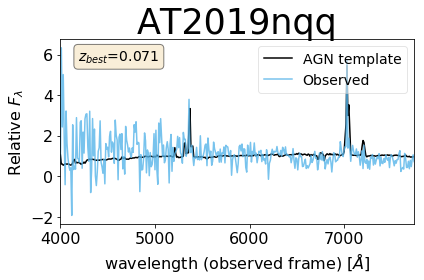

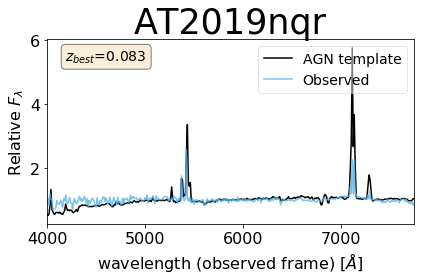

In [6]:
for inputFile_obs in inputFile_obs_list:
    
    fullInputFile_obs = os.path.join(inputFile_obs_dirname, inputFile_obs)
    print 
    print fullInputFile_obs
    
    obsname = os.path.basename(inputFile_obs)
    print obsname 
    obsname_clean = cleanName_obs_dict[inputFile_obs]

    
    df_obs = pd.read_csv(fullInputFile_obs, sep='\s+', header = None, names = ['LAMBDA', 'FLUX'])
    
    lambda_lo = df_obs.LAMBDA.min()
    lambda_hi = df_obs.LAMBDA.max()

    wavelength_array = np.arange(lambda_lo, lambda_hi, 10.)

    spec_flux_obs = interpolate.interp1d(df_obs.LAMBDA, df_obs.FLUX,bounds_error=False, fill_value=0.,kind='linear')
    spec_flux_obs_array = spec_flux_obs(wavelength_array)

    df_obs_new = pd.DataFrame({'LAMBDA':wavelength_array, 'FLUX':spec_flux_obs_array})

    norm = df_obs_new['FLUX'].median()
    df_obs['normFLUX'] = df_obs['FLUX']/norm
    df_obs_new['normFLUX'] = df_obs_new['FLUX']/norm


    agn_name = agn_dict[inputFile_obs]
    z = z_dict[inputFile_obs]
    status = plot_obs_and_bestfit_agn(obsname, obsname_clean, 
                                      agn_dirname, agn_name, z, 
                                      wavelength_array, df_obs_new, 
                                      output_dirname)
    
    #print obsname, obsname_clean, agn_dirname, agn_name, z, output_dirname